# 🏥 Çanakkale Devlet Hastanesi’nde Böbrek Donör-Hasta Eşleştirme Optimizasyonu

## 📌 Problem Senaryosu

Çanakkale Devlet Hastanesi’nde, böbrek nakli bekleyen 100 hasta, canlı donör aracılığıyla tedavi edilmeyi beklemektedir. Bu süreçte 10 gönüllü donör böbrek bağışlamayı kabul etmiştir. Ancak her donör, yalnızca bir hastaya böbrek verebilir. Benzer şekilde, her hasta yalnızca bir donörden böbrek alabilir.

Hastane yönetimi, bu kritik eşleşmeleri yaparken aşağıdaki tıbbi ve etik kriterleri dikkate almak istemektedir:

### 🎯 Eşleşme Kriterleri:

1. **Kan Grubu Uyumluluğu**  
   Yalnızca uygun kan grubu kombinasyonları geçerlidir. Uyumsuzluk durumunda bağış mümkün değildir.

2. **HLA Uyumluluğu (Histocompatibility Score)**  
   Her hasta-donör çifti için 0 ile 10 arasında bir uyum skoru mevcuttur. Bu skor, bağışın immünolojik başarısını yansıtır.

3. **Bekleme Süresi (Nakil Önceliği)**  
   Her hastanın nakil için bekleme süresi (ay olarak) tanımlanır. Daha uzun süre bekleyen hastalara öncelik verilmesi hedeflenir.

## 📐 Matematiksel Modelleme (QUBO)

### 🔢 Parametreler

- $D = \{1, 2, \dots, 10\}$: Donör kümesi  
- $H = \{1, 2, \dots, 100\}$: Hasta kümesi  
- $\text{HLA}_{dh} \in [0, 10]$: Donör $d$ ile hasta $h$ arasındaki HLA uyum skoru  
- $W_h \in \mathbb{N}$: Hasta $h$’nin bekleme süresi (ay olarak)  
- $K_{dh} \in \{0,1\}$: Donör-hasta kan uyumu (1: uyumlu, 0: uyumsuz)  
- $\alpha, \beta$: Ağırlık katsayıları (örneğin $\alpha = 0.7, \beta = 0.3$)  

### 🧮 Karar Değişkenleri

$$
x_{dh} =
\begin{cases}
1, & \text{donör } d \text{ hastaya } h \text{ organ verirse} \\
0, & \text{aksi halde}
\end{cases}
$$

---

### 🎯 Amaç Fonksiyonu

$$
\max \sum_{d \in D} \sum_{h \in H} K_{dh} \cdot (\alpha \cdot \text{HLA}_{dh} + \beta \cdot W_h) \cdot x_{dh}
$$

Bu fonksiyon, yalnızca kan uyumlu çiftleri dikkate alarak **toplam eşleşme kalitesini** maksimize eder.

---

### 🔒 Kısıtlar

1. **Her donör en fazla bir hastaya organ verebilir**:

$$
\sum_{h \in H} x_{dh} \leq 1 \quad \forall d \in D
$$

2. **Her hasta en fazla bir donörden organ alabilir**:

$$
\sum_{d \in D} x_{dh} \leq 1 \quad \forall h \in H
$$

---

### 🧠 QUBO Formülasyonu

Negatif amaç fonksiyonu minimize edilir ve kısıtlar ceza terimleriyle entegre edilir:

$$
\min \left( -\sum_{d,h} S_{dh} \cdot x_{dh} + \lambda_1 \sum_{d} \left(\sum_{h} x_{dh} - 1\right)^2 + \lambda_2 \sum_{h} \left(\sum_{d} x_{dh} - 1\right)^2 \right)
$$

Burada:

- $S_{dh} = K_{dh} \cdot (\alpha \cdot \text{HLA}_{dh} + \beta \cdot W_h)$  
- $\lambda_1, \lambda_2$: Ceza katsayıları (örneğin $\lambda_1 = \lambda_2 = 10$)

---

## 🧪 Çözümleme ve Uygulama

Bu model, aşağıdaki adımlar izlenerek D-Wave Ocean SDK ile çözülebilir:

1. Veri seti oluşturulur (HLA skoru, bekleme süresi, kan uyumu matrisi).
2. QUBO matrisi oluşturulur.
3. `BinaryQuadraticModel` ile model tanımlanır.
4. `SimulatedAnnealingSampler` veya `LeapHybridSampler` ile çözüm elde edilir.
5. Sonuçlar görselleştirilir:
   - Donör-hasta eşleşmeleri  
   - Toplam eşleşme skoru  
   - Eşleşemeyen hastalar

---



In [2]:
#Donör-Hasta Eşleştirme Python Kodu (QUBO, Ocean SDK)
import numpy as np
import pandas as pd
from dimod import BinaryQuadraticModel
from neal import SimulatedAnnealingSampler

# Parametreler
n_donors = 10
n_patients = 50
alpha = 0.7
beta = 0.3
lambda_1 = 10
lambda_2 = 10
np.random.seed(42)

# Veri Üretimi
hla_scores = np.random.randint(0, 11, size=(n_donors, n_patients))  # 0-10
waiting_times = np.random.randint(1, 61, size=n_patients)  # 1-60 ay
blood_compatibility = np.random.choice([0, 1], size=(n_donors, n_patients), p=[0.2, 0.8])  # 80% uyumlu

# Skor matrisi: Yalnızca uyumlu olanlar için geçerli
S = blood_compatibility * (alpha * hla_scores + beta * waiting_times)

# QUBO modeli
bqm = BinaryQuadraticModel('BINARY')

# Amaç fonksiyonu: Maksimize edilecek kalite
for d in range(n_donors):
    for h in range(n_patients):
        var = f"x_{d}_{h}"
        bqm.add_variable(var, -S[d, h])  # Maksimizasyon için negatif

# Kısıt 1: Her donör sadece bir hastaya verebilir
for d in range(n_donors):
    vars_d = [f"x_{d}_{h}" for h in range(n_patients)]
    for i in range(len(vars_d)):
        bqm.add_variable(vars_d[i], lambda_1)
        for j in range(i + 1, len(vars_d)):
            bqm.add_interaction(vars_d[i], vars_d[j], 2 * lambda_1)

# Kısıt 2: Her hasta sadece bir donörden alabilir
for h in range(n_patients):
    vars_h = [f"x_{d}_{h}" for d in range(n_donors)]
    for i in range(len(vars_h)):
        bqm.add_variable(vars_h[i], lambda_2)
        for j in range(i + 1, len(vars_h)):
            bqm.add_interaction(vars_h[i], vars_h[j], 2 * lambda_2)

# Örnekleme
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=100)
best = sampleset.first.sample

# Sonuçları çıkar
matches = []
for var, val in best.items():
    if val == 1:
        d, h = map(int, var.split('_')[1:])
        matches.append((d, h))

# DataFrame ile yazdır
df = pd.DataFrame(matches, columns=["Donör", "Hasta"])
print("\n📋 Donör-Hasta Eşleşmeleri:")
print(df.sort_values(by="Donör").reset_index(drop=True))



📋 Donör-Hasta Eşleşmeleri:
   Donör  Hasta
0      0      6
1      1     36
2      2     27
3      3     24
4      4     22
5      5      8
6      6      1
7      7     11
8      8     15
9      9      5


In [3]:
print("\n🎯 Eşleşme Kalite Detayları:")
total_score = 0
for donor, patient in matches:
    hla = hla_scores[donor, patient]
    wait = waiting_times[patient]
    compatibility = blood_compatibility[donor, patient]
    score = compatibility * (alpha * hla + beta * wait)
    total_score += score
    print(f"Donör {donor} ↔ Hasta {patient} | HLA: {hla}, Bekleme: {wait} ay, Skor: {score:.2f}")

print(f"\n🏆 Toplam Eşleşme Skoru: {total_score:.2f}")



🎯 Eşleşme Kalite Detayları:
Donör 0 ↔ Hasta 6 | HLA: 9, Bekleme: 53 ay, Skor: 22.20
Donör 1 ↔ Hasta 36 | HLA: 8, Bekleme: 55 ay, Skor: 22.10
Donör 2 ↔ Hasta 27 | HLA: 10, Bekleme: 49 ay, Skor: 21.70
Donör 3 ↔ Hasta 24 | HLA: 10, Bekleme: 48 ay, Skor: 21.40
Donör 4 ↔ Hasta 22 | HLA: 10, Bekleme: 49 ay, Skor: 21.70
Donör 5 ↔ Hasta 8 | HLA: 10, Bekleme: 45 ay, Skor: 20.50
Donör 6 ↔ Hasta 1 | HLA: 10, Bekleme: 51 ay, Skor: 22.30
Donör 7 ↔ Hasta 11 | HLA: 9, Bekleme: 56 ay, Skor: 23.10
Donör 8 ↔ Hasta 15 | HLA: 9, Bekleme: 57 ay, Skor: 23.40
Donör 9 ↔ Hasta 5 | HLA: 9, Bekleme: 58 ay, Skor: 23.70

🏆 Toplam Eşleşme Skoru: 222.10


/tmp/ipykernel_3506117/754010164.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


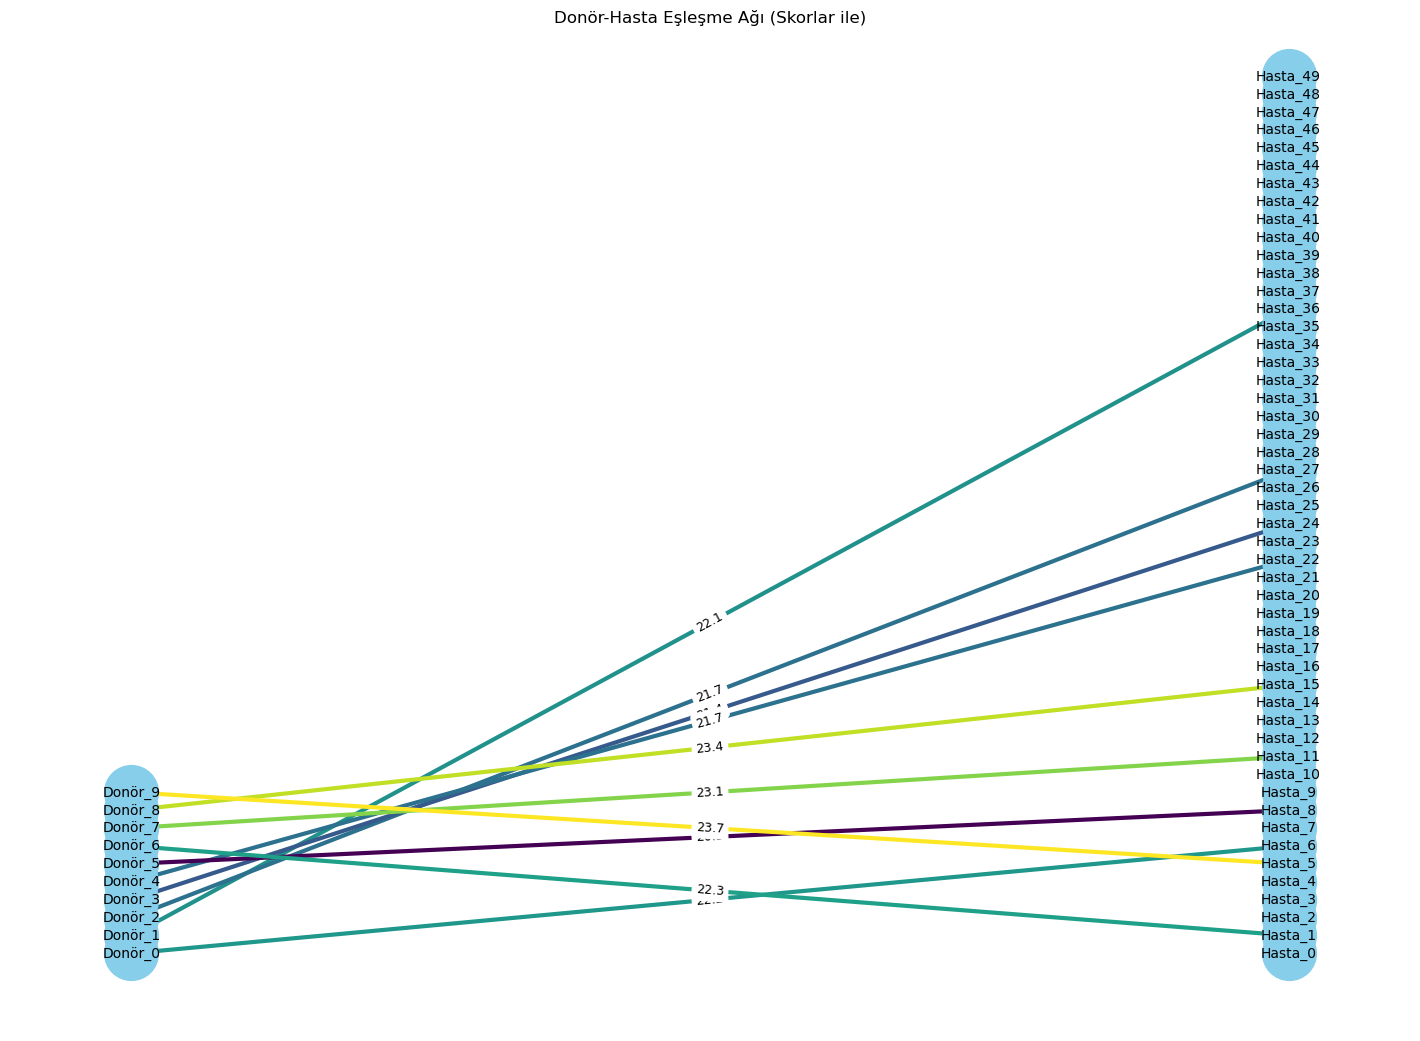

In [4]:
import matplotlib.pyplot as plt
import networkx as nx

# Yeni bir yönsüz grafik oluştur
G = nx.Graph()

# Donör ve hasta düğümlerini tanımla
donor_nodes = [f"Donör_{d}" for d in range(n_donors)]
patient_nodes = [f"Hasta_{h}" for h in range(n_patients)]
G.add_nodes_from(donor_nodes, bipartite=0)
G.add_nodes_from(patient_nodes, bipartite=1)

# Kenarları (eşleşmeleri) ekle
for donor, patient in matches:
    donor_name = f"Donör_{donor}"
    patient_name = f"Hasta_{patient}"
    hla = hla_scores[donor, patient]
    wait = waiting_times[patient]
    weight = blood_compatibility[donor, patient] * (alpha * hla + beta * wait)
    G.add_edge(donor_name, patient_name, weight=round(weight, 2))

# Düğüm pozisyonları (bipartite layout)
pos = {}
pos.update((node, (1, i)) for i, node in enumerate(donor_nodes))   # Donörler solda
pos.update((node, (2, i)) for i, node in enumerate(patient_nodes)) # Hastalar sağda

# Renk ve kalınlıklar
edge_labels = nx.get_edge_attributes(G, 'weight')
edges = G.edges()
weights = [edge_labels[e] for e in edges]

# Çizim
plt.figure(figsize=(14, 10))
nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=1500, font_size=10, edge_color=weights, width=3, edge_cmap=plt.cm.viridis)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, label_pos=0.5)
plt.title("Donör-Hasta Eşleşme Ağı (Skorlar ile)")
plt.axis("off")
plt.tight_layout()
plt.show()


In [5]:
incompatible_blood = []
for h in range(n_patients):
    if all(blood_compatibility[d, h] == 0 for d in range(n_donors)):
        incompatible_blood.append(h)


In [6]:
low_hla_patients = []
for h in range(n_patients):
    max_hla = max(hla_scores[d, h] for d in range(n_donors) if blood_compatibility[d, h])
    if max_hla < 4:  # eşik değer (4) altında
        low_hla_patients.append(h)


In [7]:
short_waiting = [h for h in range(n_patients) if waiting_times[h] < 6]  # <6 ay


In [8]:
matched_patients = set(h for _, h in matches)
unmatched_patients = set(range(n_patients)) - matched_patients

print("🩸 Kan uyumsuzluğu nedeniyle eşleşemeyen hasta sayısı:", len(set(incompatible_blood) & unmatched_patients))
print("🧬 HLA skoru çok düşük olduğu için eşleşemeyen hasta sayısı:", len(set(low_hla_patients) & unmatched_patients))
print("⏳ Bekleme süresi kısa olduğu için eşleşemeyen hasta sayısı:", len(set(short_waiting) & unmatched_patients))
print("📉 Sadece donör kontenjanı dolduğu için eşleşemeyen hasta sayısı:", 
      len(unmatched_patients - set(incompatible_blood) - set(low_hla_patients) - set(short_waiting)))


🩸 Kan uyumsuzluğu nedeniyle eşleşemeyen hasta sayısı: 0
🧬 HLA skoru çok düşük olduğu için eşleşemeyen hasta sayısı: 0
⏳ Bekleme süresi kısa olduğu için eşleşemeyen hasta sayısı: 1
📉 Sadece donör kontenjanı dolduğu için eşleşemeyen hasta sayısı: 39
